<a href="https://colab.research.google.com/github/creepereye1204/HomeWork/blob/main/CNN/20230325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle --upgrade

In [2]:

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files
files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

In [7]:
import os
os.mkdir('/content/train')
os.mkdir('/content/test')
os.mkdir('/content/eval')

In [ ]:
!unzip /content/plant-pathology-2021-fgvc8.zip -d /content/

In [9]:
import pandas as pd

In [10]:
train=pd.read_csv('/content/train.csv')

In [11]:
for dir in ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']:
  os.makedirs('/content/train/'+dir)
  os.makedirs('/content/test/'+dir)
  os.makedirs('/content/eval/'+dir)

In [12]:
new=pd.DataFrame(columns=['image','labels'])
for idx,(image,label) in enumerate(train.values):
  n=len(label.split())
  if n!=1:
    cols= ['image','labels']	
    for i in label.split():
      add_row = [[image,i]]	

      row_df = pd.DataFrame(data = add_row, columns = cols)	
                            
      new = pd.concat([new, row_df], ignore_index = True)
    train.drop(labels=idx,axis=0,inplace=True)

In [13]:
train=pd.concat([new,train],ignore_index=True)

In [14]:
train,other=train_test_split(train,  train_size= 0.6, shuffle= True, random_state= 42)
test,eval=train_test_split(other,  train_size= 0.5, shuffle= True, random_state= 42)

In [15]:
import shutil
def move(data,where):
  path='/content/train_images/'
  for name,label in data.values:
    if os.path.exists(path+name):
        shutil.move(path+name,"/content/"+where+"/"+label+'/'+name)

In [16]:
for key,value in {'train':train,'test':test,'eval':eval}.items():
  move(value,key)

In [ ]:
train['labels'].isnull().sum()

In [ ]:
train['labels'].value_counts()

In [19]:
import matplotlib.pyplot as plt


<Axes: >

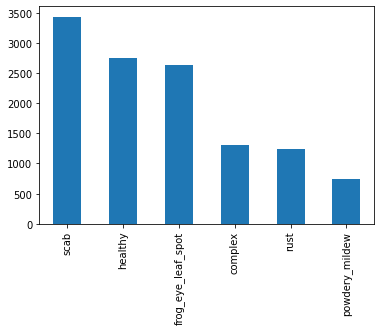

In [20]:
train['labels'].value_counts().plot(kind='bar')

In [ ]:
len(train)

In [ ]:
test

In [23]:
eval

,image,labels
14415,d64763342d8b568d.jpg,scab
12484,c797d09a486925be.jpg,healthy
10512,ba84d297977c0359.jpg,frog_eye_leaf_spot
14927,da979553d822352e.jpg,scab
3582,850367cf187768d6.jpg,rust
...,...,...
3168,81b74d197aec78d0.jpg,frog_eye_leaf_spot
7806,a8be209f5a8f3f01.jpg,scab
10735,bcbdca83444f309e.jpg,rust
14695,d8b533ee152daa60.jpg,frog_eye_leaf_spot


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [65]:
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [66]:
if torch.cuda.is_available():
  device=torch.device('cuda')

trans_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_eval=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root='/content/train', 
                                    transform=trans_train,
                                   )
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,drop_last=True)

test_data = datasets.ImageFolder(root='/content/test', 
                                    transform=trans_test
                                   )
test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=True,drop_last=True)

eval_data = datasets.ImageFolder(root='/content/eval', 
                                    transform=trans_eval
                                   )
eval_loader=DataLoader(dataset=eval_data,batch_size=32,shuffle=True,drop_last=True)

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
real_batch=next(iter(train_loader))

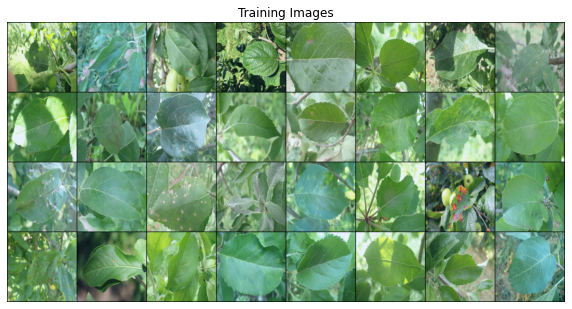

In [68]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0],padding=2,normalize=True).cpu(),(1,2,0)));

In [69]:

num_class=6
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
  
        self.layer4 = self._make_layer(32, 2, stride = 2)#28*28
        self.layer5 = self._make_layer(16, 2, stride = 2)
        self.linear = nn.Linear(3136, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # out = self.layer4(out)

        # out = self.layer5(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [88]:
R=ResNet().to(device)

In [89]:
if os.path.exists('/content/drive/MyDrive/Plant_Pathology.pth'):
  R.load_state_dict(torch.load('/content/drive/MyDrive/Plant_Pathology.pth'))

In [90]:
criterion=nn.CrossEntropyLoss()

In [91]:
import torch.optim as optim
optim=optim.Adam(R.parameters(),lr=0.0002)

In [92]:
def train(R,optim,cri):
 
  for epoch in range(3):
    for index,sample in enumerate(train_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      optim.zero_grad()
      cost.backward()
      optim.step()
      if index%10==0:
        print('epoch {} , cost: {:.4f}'.format(epoch,cost.item()))
        test(R,cri)
        R.train()
      torch.save(R.state_dict(),'/content/drive/MyDrive/Plant_Pathology.pth')

In [93]:
def test(R,cri):
  R.eval()
  correct=0
  loss_avg=0
  with torch.no_grad():
    for index,sample in enumerate(test_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      loss_avg+=cost.item()
      prediction=out.max(1,keepdim=True)[1]
      correct+=prediction.eq(Y.view_as(prediction)).sum().item()
      


  test_accuracy=100*correct/len(test_loader.dataset)
  loss_avg/=len(test_loader.dataset)
  print('cost: {:.2f}%'.format(test_accuracy))
  print('loss_avg:',loss_avg)

In [ ]:
train(R,optim,criterion)

epoch 0 , cost: 1.7941
cost: 18.25%
loss_avg: 0.058708498506154894
epoch 0 , cost: 1.6372
cost: 34.93%
loss_avg: 0.04823571605981627
epoch 0 , cost: 1.2662
cost: 33.69%
loss_avg: 0.04985661599185229
epoch 0 , cost: 1.5023
cost: 41.56%
loss_avg: 0.044023725568444284
epoch 0 , cost: 1.3408
cost: 39.77%
loss_avg: 0.044561703442017826
epoch 0 , cost: 1.4270
cost: 44.32%
loss_avg: 0.04242465537407495
epoch 0 , cost: 1.4648
cost: 44.48%
loss_avg: 0.04198747504161075
epoch 0 , cost: 1.3325
cost: 45.20%
loss_avg: 0.04173645853766587
epoch 0 , cost: 1.3718
cost: 43.90%
loss_avg: 0.041556844952806704
epoch 0 , cost: 1.5378
cost: 40.57%
loss_avg: 0.04440782964639745
epoch 0 , cost: 1.2214


In [ ]:
from google.colab import drive
drive.mount('/content/drive')